In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import kerastuner as kt
from keras_tuner.tuners import RandomSearch

In [3]:
# Define constants
image_size = (128, 128)  # Adjust the size based on your dataset
batch_size = 32

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [4]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/training',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/bone-fracture-dataset/BoneFractureDataset/testing',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [5]:
def model_builder(hp):
    model = Sequential()
    
    # Tunable CNN layers
    model.add(Conv2D(hp.Int('conv_1_filters', min_value=16, max_value=64, step=16), (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int('conv_2_filters', min_value=32, max_value=128, step=32), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(hp.Int('conv_3_filters', min_value=64, max_value=256, step=64), (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    # Tunable optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [6]:
# Define a tuner
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_dir',
    project_name='bone_fracture_tuning'
)

In [7]:
# Perform hyperparameter search
tuner.search(train_generator, epochs=10, validation_data=test_generator)

Trial 5 Complete [00h 32m 00s]
val_accuracy: 0.7350000143051147

Best val_accuracy So Far: 0.7733333110809326
Total elapsed time: 02h 56m 58s


In [8]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [12]:
print(best_hps.values)

{'conv_1_filters': 16, 'conv_2_filters': 32, 'conv_3_filters': 128, 'dense_units': 192, 'dropout_rate': 0.2, 'optimizer': 'adam'}


In [11]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('dense_units')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 192.



In [13]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10
277/277 [==============================] - 120s 427ms/step - loss: 0.6137 - accuracy: 0.6473 - val_loss: 0.6126 - val_accuracy: 0.6067
Epoch 2/10
277/277 [==============================] - 109s 395ms/step - loss: 0.4493 - accuracy: 0.7780 - val_loss: 0.5397 - val_accuracy: 0.6800
Epoch 3/10
277/277 [==============================] - 110s 395ms/step - loss: 0.3051 - accuracy: 0.8672 - val_loss: 0.6923 - val_accuracy: 0.6917
Epoch 4/10
277/277 [==============================] - 115s 413ms/step - loss: 0.2159 - accuracy: 0.9117 - val_loss: 0.5692 - val_accuracy: 0.7183
Epoch 5/10
277/277 [==============================] - 112s 402ms/step - loss: 0.1552 - accuracy: 0.9405 - val_loss: 0.6725 - val_accuracy: 0.7133
Epoch 6/10
277/277 [==============================] - 106s 383ms/step - loss: 0.1191 - accuracy: 0.9548 - val_loss: 0.7164 - val_accuracy: 0.7517
Epoch 7/10
277/277 [==============================] - 109s 392ms/step - loss: 0.0989 - accuracy: 0.9641 - val_loss: 0.7935 -

In [14]:
# Evaluate the model
evaluation = model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

19/19 [==============================] - 2s 112ms/step - loss: 0.8351 - accuracy: 0.7333
Test Accuracy: 73.33%


In [15]:
# Make predictions on new data
predictions = model.predict(test_generator)

19/19 [==============================] - 2s 114ms/step


In [16]:
# Convert predictions to binary labels
predicted_labels = (predictions > 0.5).astype(int)

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels
true_labels = test_generator.classes

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[163 197]
 [ 95 145]]


In [18]:
# Generate classification report
class_report = classification_report(true_labels, predicted_labels, target_names=['not_fractured', 'fractured'])
print("Classification Report:")
print(class_report)

Classification Report:
               precision    recall  f1-score   support

not_fractured       0.63      0.45      0.53       360
    fractured       0.42      0.60      0.50       240

     accuracy                           0.51       600
    macro avg       0.53      0.53      0.51       600
 weighted avg       0.55      0.51      0.52       600



1/1 [==============================] - 0s 158ms/step


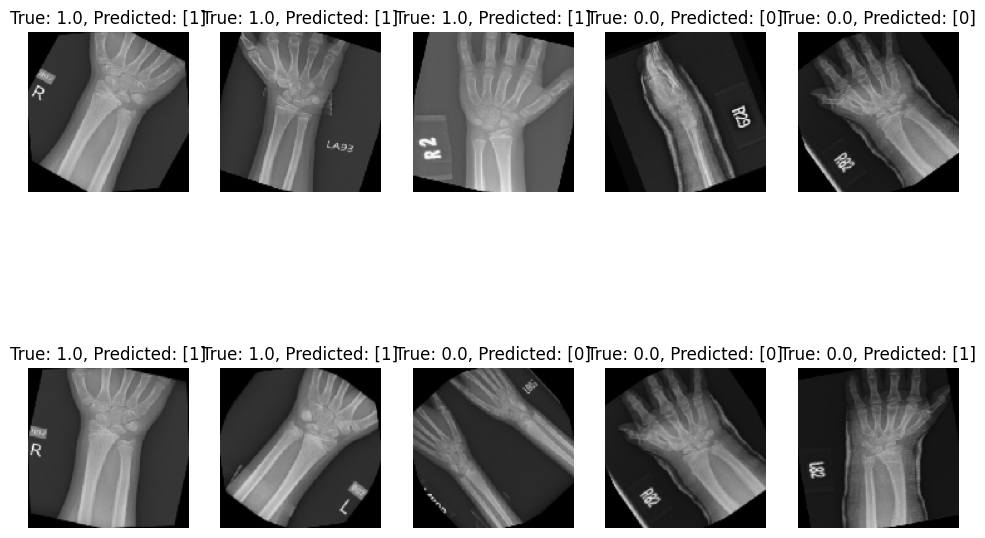

In [19]:
import matplotlib.pyplot as plt
import random

# Visualize random predictions
test_images, true_labels = next(test_generator)
predicted_labels = (model.predict(test_images) > 0.5).astype(int)

# Plot some sample images with true and predicted labels
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(test_images[i])
    plt.title(f"True: {true_labels[i]}, Predicted: {predicted_labels[i]}")
    plt.axis('off')
plt.show()